In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import  MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from pandas.tseries.offsets import CustomBusinessMonthBegin

In [45]:
df = pd.read_csv('sp500_Adjclose.csv')

df['Date'] = pd.to_datetime(df.Date)

df.set_index('Date', inplace=True)


In [46]:
ticker = input('> What is the ticker for the company'
               ' whose adjusted close value you want to predict for? \n>').upper()

df = df.loc[:,[f'{ticker}']]

df = df.resample('1M').mean()

> What is the ticker for the company whose adjusted close value you want to predict for? 
>mmm


In [47]:
len(df)

test_size = int(input("> Ideally less than 24 months \n"))

len(df)- test_size

> Ideally less than 24 months 
18


224

In [48]:
test_ind = len(df)- test_size

In [49]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [50]:
train

,MMM
Date,
2000-01-31,26.994161
2000-02-29,24.795302
2000-03-31,24.288003
2000-04-30,25.987985
2000-05-31,24.487872
...,...
2018-04-30,199.112898
2018-05-31,188.358998
2018-06-30,189.831294


In [51]:
test

,MMM
Date,
2018-09-30,201.264673
2018-10-31,190.910536
2018-11-30,191.170284
2018-12-31,186.176839
2019-01-31,184.784626
2019-02-28,197.726914
2019-03-31,199.081088
2019-04-30,203.466542
2019-05-31,166.782777


In [52]:
scaler = MinMaxScaler()

In [53]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [54]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [55]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [56]:
X,y = generator[0]

In [57]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.01413175 0.00341863 0.000947   0.00922953 0.00192079 0.
 0.00541476 0.01391027 0.00766245 0.01263887 0.0194618  0.04550258]
Predict this y: 
 [[0.04239666]]


In [58]:
n_features = 1

In [59]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [61]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [62]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [63]:
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
212/212 [==============================] - 6s 28ms/step - loss: 0.0161 - val_loss: 0.0023
Epoch 2/20
212/212 [==============================] - 4s 18ms/step - loss: 0.0022 - val_loss: 0.0119
Epoch 3/20
212/212 [==============================] - 4s 18ms/step - loss: 0.0032 - val_loss: 0.0056


In [64]:
losses = pd.DataFrame(model.history.history)

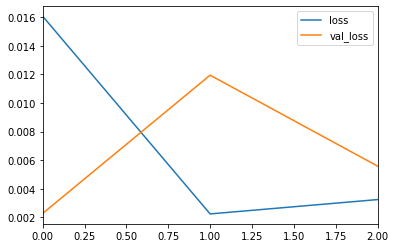

In [65]:
losses.plot()

In [66]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    

In [67]:
true_predictions = scaler.inverse_transform(test_predictions)

In [68]:
test['Predictions'] = true_predictions

C:\Users\khatt\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
test

,MMM,Predictions
Date,,
2018-09-30,201.264673,209.272694
2018-10-31,190.910536,210.655823
2018-11-30,191.170284,211.669394
2018-12-31,186.176839,211.901335
2019-01-31,184.784626,211.823430
2019-02-28,197.726914,211.561798
2019-03-31,199.081088,211.844655
2019-04-30,203.466542,212.423950
2019-05-31,166.782777,213.820928


In [70]:
true_predictions = scaler.inverse_transform(test_predictions)

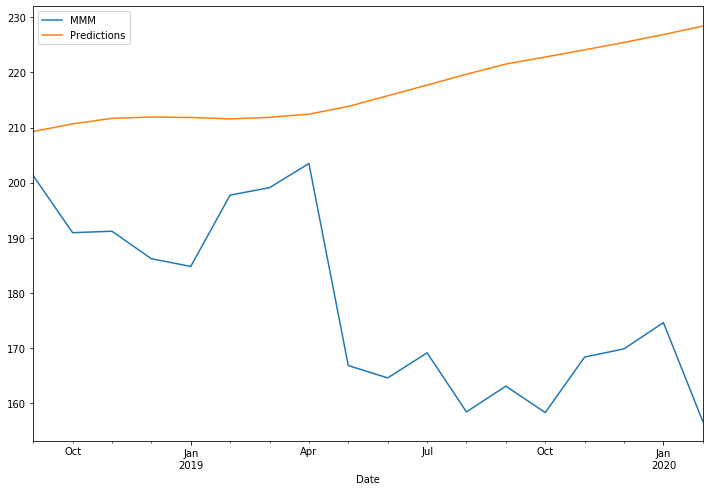

In [71]:
test.plot(figsize=(12,8))

In [72]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [73]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [74]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


# fit model
model.fit_generator(generator,epochs=8)

Epoch 1/8
230/230 [==============================] - 7s 31ms/step - loss: 0.0199
Epoch 2/8
230/230 [==============================] - 5s 20ms/step - loss: 0.0038
Epoch 3/8
230/230 [==============================] - 4s 19ms/step - loss: 0.0029
Epoch 4/8
230/230 [==============================] - 4s 19ms/step - loss: 0.0026
Epoch 5/8
230/230 [==============================] - 5s 20ms/step - loss: 0.0029
Epoch 6/8
230/230 [==============================] - 4s 19ms/step - loss: 0.0021
Epoch 7/8
230/230 [==============================] - 5s 22ms/step - loss: 0.0022
Epoch 8/8
230/230 [==============================] - 5s 21ms/step - loss: 0.0025


In [75]:
forecast = []

In [76]:
periods = 12

In [77]:
first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

In [78]:
for i in range(periods):
    current_pred = model.predict(current_batch)[0]
    
    forecast.append(current_pred) 
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    

In [79]:
forecast = scaler.inverse_transform(forecast)

In [80]:
df

,MMM
Date,
2000-01-31,26.994161
2000-02-29,24.795302
2000-03-31,24.288003
2000-04-30,25.987985
2000-05-31,24.487872
...,...
2019-10-31,158.249711
2019-11-30,168.334397
2019-12-31,169.818376


In [81]:
forecast_index = pd.date_range(start='2020-02-29',periods=periods,freq='MS')

In [82]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [83]:
forecast_df

,Forecast
2020-03-01,172.270936
2020-04-01,173.242801
2020-05-01,174.247196
2020-06-01,175.260277
2020-07-01,176.397434
2020-08-01,177.736326
2020-09-01,179.375887
2020-10-01,180.651029
2020-11-01,181.983155
2020-12-01,183.182716


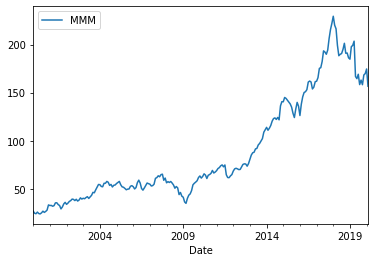

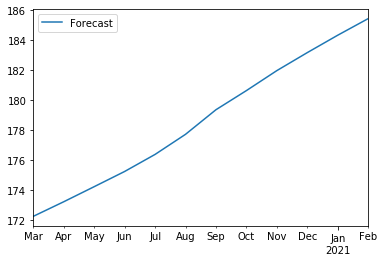

In [84]:
df.plot()
forecast_df.plot()

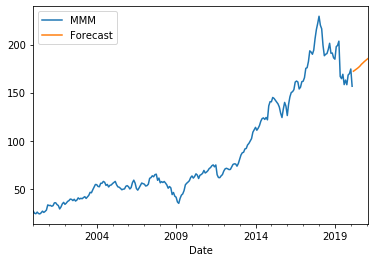

In [85]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 623)

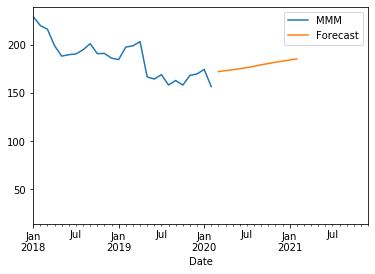

In [86]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2021-12-01')